# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-08-04 09:31:48.292520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 09:31:48.816873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('all.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [5]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], data_tags.index(annotations[i]['label'])])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], data_tags.index(annotations[-1]['label'])])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[a[1]+1]] * t
                if a[1] != 0:
                    temp[0] = data_tags[a[1]]
                labels.extend(temp)
 
    return labels, sentences

In [6]:
def reduce(sent, label, slist, llist):
    lens = len(sent)
    if lens < 256:
        slist.append(sent)
        llist.append(label)
    else:
        t = lens//2
        return reduce(sent[:t], label[:t], slist, llist), reduce(sent[t:], label[t:], slist, llist)

In [7]:
#create labels
data_tags = ['ahhhhhhhhhhhhhhhhhhhh','0','Metal', 'M-cont' , 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield' , 'Y-cont', 'Separation Method' , 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']

sent_test, label_test = [], []
sentences, labels = [], []

for i in range(len(info)):
    l, s = pre_process(info[i]['text'], info[i]['entities'])
  
    if i % 5 == 0:
        reduce(s,l,sent_test, label_test)

    else:
        reduce(s,l,sentences, labels)


data_tags = data_tags[1:]


In [8]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']
['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont', 'PAD']
{'0': 0, 'Metal': 1, 'M-cont': 2, 'Element': 3, 'E-cont': 4, 'Acid': 5, 'A-cont': 6, 'Yield': 7, 'Y-cont': 8, 'Separation Method': 9, 'S-cont': 10, 'Resin': 11, 'R-cont': 12, 'Method of Analysis': 13, 'T-cont': 14, 'pH': 15, 'P-cont': 16, 'Chemi

In [9]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=False)


In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        
        n_subwords = len(tokenized_word)
        #print(word, tokenized_word, n_subwords)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [13]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [14]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 512 # 64 or 128 or ...
bs = 8 # batch size


In [15]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [16]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [17]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [18]:
# Load SciBERT Model

model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [19]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [20]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 3e-5, # learning-rate default is 3e-5
    eps=1e-20 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
epochs = 100

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)

# **Training**

In [22]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        
        s, l= tokenize_and_preserve_labels(sentences[i], labels[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [23]:
def acc_test(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sent_test)):
       
        
        s, label_test[i] = tokenize_and_preserve_labels(sent_test[i], label_test[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, label_test[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",label_test[i])
            print()
            print()
            if special == i:
                for j in range(len(sent_test[i])):
                    print(sent_test[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [24]:
from torch import nn
from transformers import Trainer
w = [.99, 0.0008, .0008, .99,.99, .0319, .0319, .0239, .0239, .0736, .0736, .0135, .0135, .0526, .0526, .0083, .0083, .0463, .0436, .0324, .0324, .0324, .014, .014, .0386, .0386, .0004, .0004, .0293, .0293, .0421, .0421]
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(w))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [25]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif  max_test * 1.05 >= a and max_test < a:    
        torch.save(model, "check.ck")
torch.save(model, "end.ck")

Epoch:   0%|                                                                                                                  | 0/100 [00:00<?, ?it/s]


Average train loss: 0.6751385862246538


Epoch:   1%|█                                                                                                         | 1/100 [00:11<18:27, 11.19s/it]


Validation loss: 0.2518248200416565
Validation Accuracy: 0.8531367447239087


Average train loss: 0.19105056654184294


Epoch:   2%|██                                                                                                        | 2/100 [00:21<17:51, 10.94s/it]


Validation loss: 0.15737996399402618
Validation Accuracy: 0.8966464296039318


Average train loss: 0.13111711522707573


Epoch:   3%|███▏                                                                                                      | 3/100 [00:32<17:34, 10.87s/it]


Validation loss: 0.13230331540107726
Validation Accuracy: 0.9071986123156982


Average train loss: 0.09146393940616877


Epoch:   4%|████▏                                                                                                     | 4/100 [00:43<17:23, 10.87s/it]


Validation loss: 0.13174712061882018
Validation Accuracy: 0.9099450708297195


Average train loss: 0.0683430349215483


Epoch:   5%|█████▎                                                                                                    | 5/100 [00:54<17:12, 10.87s/it]


Validation loss: 0.1294893279671669
Validation Accuracy: 0.9122578779994218


Average train loss: 0.05172667475656057


Epoch:   6%|██████▎                                                                                                   | 6/100 [01:05<17:03, 10.89s/it]


Validation loss: 0.14347307682037352
Validation Accuracy: 0.9032957502168256


Average train loss: 0.03951904617058925


Epoch:   7%|███████▍                                                                                                  | 7/100 [01:16<16:54, 10.91s/it]


Validation loss: 0.138955220580101
Validation Accuracy: 0.9216536571263371


Average train loss: 0.030540473078592464


Epoch:   8%|████████▍                                                                                                 | 8/100 [01:27<16:45, 10.93s/it]


Validation loss: 0.1365901231765747
Validation Accuracy: 0.9199190517490604


Average train loss: 0.022637905260452475


Epoch:   9%|█████████▌                                                                                                | 9/100 [01:38<16:35, 10.94s/it]


Validation loss: 0.14230147302150725
Validation Accuracy: 0.9203527030933796


Average train loss: 0.018148213147352904


Epoch:  10%|██████████▌                                                                                              | 10/100 [01:49<16:24, 10.94s/it]


Validation loss: 0.14215495586395263
Validation Accuracy: 0.9132697311361665


Average train loss: 0.015843062876508787


Epoch:  11%|███████████▌                                                                                             | 11/100 [02:00<16:11, 10.92s/it]


Validation loss: 0.1532857209444046
Validation Accuracy: 0.9209309048858051


Average train loss: 0.013440968922506541


Epoch:  12%|████████████▌                                                                                            | 12/100 [02:11<16:01, 10.93s/it]


Validation loss: 0.14806545674800872
Validation Accuracy: 0.9228100607111882


Average train loss: 0.01087789888231036


Epoch:  13%|█████████████▋                                                                                           | 13/100 [02:22<15:51, 10.94s/it]


Validation loss: 0.14669881910085678
Validation Accuracy: 0.9232437120555074


Average train loss: 0.009209966460147347


Epoch:  14%|██████████████▋                                                                                          | 14/100 [02:33<15:42, 10.96s/it]


Validation loss: 0.15913954228162766
Validation Accuracy: 0.9235328129517202


Average train loss: 0.008405676039938744


Epoch:  15%|███████████████▊                                                                                         | 15/100 [02:44<15:33, 10.98s/it]


Validation loss: 0.15565449595451356
Validation Accuracy: 0.9259901705695288


Average train loss: 0.007441410967984643


Epoch:  16%|████████████████▊                                                                                        | 16/100 [02:55<15:24, 11.00s/it]


Validation loss: 0.16867410242557526
Validation Accuracy: 0.9239664642960393


Average train loss: 0.006693737744055211


Epoch:  17%|█████████████████▊                                                                                       | 17/100 [03:06<15:14, 11.02s/it]


Validation loss: 0.166260227560997
Validation Accuracy: 0.9254119687771032


Average train loss: 0.005865050237984038


Epoch:  18%|██████████████████▉                                                                                      | 18/100 [03:17<15:04, 11.03s/it]


Validation loss: 0.165441532433033
Validation Accuracy: 0.9258456201214224


Average train loss: 0.005461221205619857


Epoch:  19%|███████████████████▉                                                                                     | 19/100 [03:28<14:53, 11.03s/it]


Validation loss: 0.1584870457649231
Validation Accuracy: 0.9270020237062735


Average train loss: 0.005405962279138084


Epoch:  20%|█████████████████████                                                                                    | 20/100 [03:39<14:42, 11.03s/it]


Validation loss: 0.16527462899684905
Validation Accuracy: 0.9255565192252097


Average train loss: 0.004745701181654556


Epoch:  21%|██████████████████████                                                                                   | 21/100 [03:50<14:31, 11.04s/it]


Validation loss: 0.16894038170576095
Validation Accuracy: 0.9261347210176352


Average train loss: 0.004892254824368045


Epoch:  22%|███████████████████████                                                                                  | 22/100 [04:01<14:20, 11.04s/it]


Validation loss: 0.1726452440023422
Validation Accuracy: 0.9229546111592946


Average train loss: 0.004458796444874353


Epoch:  23%|████████████████████████▏                                                                                | 23/100 [04:12<14:10, 11.04s/it]


Validation loss: 0.1661023512482643
Validation Accuracy: 0.925701069673316


Average train loss: 0.0038600846563871852


Epoch:  24%|█████████████████████████▏                                                                               | 24/100 [04:23<13:58, 11.03s/it]


Validation loss: 0.18034964054822922
Validation Accuracy: 0.9251228678808904


Average train loss: 0.003837193150479251


Epoch:  25%|██████████████████████████▎                                                                              | 25/100 [04:34<13:46, 11.02s/it]


Validation loss: 0.17622661143541335
Validation Accuracy: 0.9255565192252097


Average train loss: 0.003773545888133156


Epoch:  26%|███████████████████████████▎                                                                             | 26/100 [04:45<13:35, 11.02s/it]


Validation loss: 0.17765052169561385
Validation Accuracy: 0.9244001156403585


Average train loss: 0.0038451350649269535


Epoch:  27%|████████████████████████████▎                                                                            | 27/100 [04:56<13:25, 11.03s/it]


Validation loss: 0.17656438946723937
Validation Accuracy: 0.9262792714657415


Average train loss: 0.003295155791326975


Epoch:  28%|█████████████████████████████▍                                                                           | 28/100 [05:07<13:14, 11.04s/it]


Validation loss: 0.1800211638212204
Validation Accuracy: 0.924978317432784


Average train loss: 0.0032603417445595064


Epoch:  29%|██████████████████████████████▍                                                                          | 29/100 [05:18<13:03, 11.04s/it]


Validation loss: 0.18471434712409973
Validation Accuracy: 0.9254119687771032


Average train loss: 0.0031830500445674914


Epoch:  30%|███████████████████████████████▌                                                                         | 30/100 [05:29<12:52, 11.04s/it]


Validation loss: 0.18074836432933808
Validation Accuracy: 0.9271465741543798


Average train loss: 0.003414785307354461


Epoch:  31%|████████████████████████████████▌                                                                        | 31/100 [05:40<12:42, 11.04s/it]


Validation loss: 0.1862797498703003
Validation Accuracy: 0.9259901705695288


Average train loss: 0.003098821389870957


Epoch:  32%|█████████████████████████████████▌                                                                       | 32/100 [05:51<12:30, 11.03s/it]


Validation loss: 0.1856085851788521
Validation Accuracy: 0.9262792714657415


Average train loss: 0.002978184558182525


Epoch:  33%|██████████████████████████████████▋                                                                      | 33/100 [06:02<12:18, 11.03s/it]


Validation loss: 0.1867993324995041
Validation Accuracy: 0.9254119687771032


Average train loss: 0.0028484713730927654


Epoch:  34%|███████████████████████████████████▋                                                                     | 34/100 [06:13<12:08, 11.03s/it]


Validation loss: 0.1868708148598671
Validation Accuracy: 0.9252674183289968


Average train loss: 0.00273887833501272


Epoch:  35%|████████████████████████████████████▊                                                                    | 35/100 [06:24<11:57, 11.03s/it]


Validation loss: 0.18677616268396377
Validation Accuracy: 0.9259901705695288


Average train loss: 0.002983301274257545


Epoch:  36%|█████████████████████████████████████▊                                                                   | 36/100 [06:35<11:46, 11.04s/it]


Validation loss: 0.18876186460256578
Validation Accuracy: 0.9251228678808904


Average train loss: 0.002657177819995783


Epoch:  37%|██████████████████████████████████████▊                                                                  | 37/100 [06:46<11:35, 11.04s/it]


Validation loss: 0.18521412834525108
Validation Accuracy: 0.9272911246024863


Average train loss: 0.002853876609617892


Epoch:  38%|███████████████████████████████████████▉                                                                 | 38/100 [06:57<11:24, 11.04s/it]


Validation loss: 0.19028956443071365
Validation Accuracy: 0.9251228678808904


Average train loss: 0.002556233329904409


Epoch:  39%|████████████████████████████████████████▉                                                                | 39/100 [07:08<11:13, 11.04s/it]


Validation loss: 0.19537535160779954
Validation Accuracy: 0.9232437120555074


Average train loss: 0.0025461606117180334


Epoch:  40%|██████████████████████████████████████████                                                               | 40/100 [07:19<11:02, 11.04s/it]


Validation loss: 0.1892957091331482
Validation Accuracy: 0.9270020237062735


Average train loss: 0.0024614795096194707


Epoch:  41%|███████████████████████████████████████████                                                              | 41/100 [07:31<10:51, 11.04s/it]


Validation loss: 0.1968500569462776
Validation Accuracy: 0.9238219138479329


Average train loss: 0.002240579736490662


Epoch:  42%|████████████████████████████████████████████                                                             | 42/100 [07:42<10:39, 11.03s/it]


Validation loss: 0.20011364072561263
Validation Accuracy: 0.9252674183289968


Average train loss: 0.00222513694405699


Epoch:  43%|█████████████████████████████████████████████▏                                                           | 43/100 [07:53<10:28, 11.02s/it]


Validation loss: 0.2002800866961479
Validation Accuracy: 0.9259901705695288


Average train loss: 0.0023441571143055814


Epoch:  44%|██████████████████████████████████████████████▏                                                          | 44/100 [08:04<10:16, 11.01s/it]


Validation loss: 0.19402415305376053
Validation Accuracy: 0.9268574732581671


Average train loss: 0.0023014383470394816


Epoch:  45%|███████████████████████████████████████████████▎                                                         | 45/100 [08:15<10:05, 11.02s/it]


Validation loss: 0.19750188440084457
Validation Accuracy: 0.9254119687771032


Average train loss: 0.00246873601169612


Epoch:  46%|████████████████████████████████████████████████▎                                                        | 46/100 [08:26<09:54, 11.01s/it]


Validation loss: 0.19553007930517197
Validation Accuracy: 0.9277247759468055


Average train loss: 0.0023513943309901664


Epoch:  47%|█████████████████████████████████████████████████▎                                                       | 47/100 [08:37<09:43, 11.01s/it]


Validation loss: 0.20097493529319763
Validation Accuracy: 0.9246892165365712


Average train loss: 0.0021850839115452403


Epoch:  48%|██████████████████████████████████████████████████▍                                                      | 48/100 [08:48<09:32, 11.01s/it]


Validation loss: 0.19986114650964737
Validation Accuracy: 0.9255565192252097


Average train loss: 0.00225066103582951


Epoch:  49%|███████████████████████████████████████████████████▍                                                     | 49/100 [08:59<09:21, 11.02s/it]


Validation loss: 0.19755832552909852
Validation Accuracy: 0.9277247759468055


Average train loss: 0.002033692957737889


Epoch:  50%|████████████████████████████████████████████████████▌                                                    | 50/100 [09:10<09:11, 11.02s/it]


Validation loss: 0.20022448152303696
Validation Accuracy: 0.9277247759468055


Average train loss: 0.0020205706394522283


Epoch:  51%|█████████████████████████████████████████████████████▌                                                   | 51/100 [09:21<09:00, 11.02s/it]


Validation loss: 0.19985438585281373
Validation Accuracy: 0.9272911246024863


Average train loss: 0.002036724535103601


Epoch:  52%|██████████████████████████████████████████████████████▌                                                  | 52/100 [09:32<08:48, 11.02s/it]


Validation loss: 0.20119768232107163
Validation Accuracy: 0.9284475281873373


Average train loss: 0.0019262937473682447


Epoch:  53%|███████████████████████████████████████████████████████▋                                                 | 53/100 [09:43<08:38, 11.02s/it]


Validation loss: 0.1962304398417473
Validation Accuracy: 0.9298930326684013


Average train loss: 0.0017923124681916446


Epoch:  54%|████████████████████████████████████████████████████████▋                                                | 54/100 [09:54<08:27, 11.03s/it]


Validation loss: 0.2037482127547264
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0017869247027332536


Epoch:  55%|█████████████████████████████████████████████████████████▊                                               | 55/100 [10:05<08:16, 11.02s/it]


Validation loss: 0.20146823823451995
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0017726410022497964


Epoch:  56%|██████████████████████████████████████████████████████████▊                                              | 56/100 [10:16<08:05, 11.03s/it]


Validation loss: 0.2051111340522766
Validation Accuracy: 0.9291702804278693


Average train loss: 0.001693689027795186


Epoch:  57%|███████████████████████████████████████████████████████████▊                                             | 57/100 [10:27<07:54, 11.02s/it]


Validation loss: 0.20661184638738633
Validation Accuracy: 0.928302977739231


Average train loss: 0.0017569967943321292


Epoch:  58%|████████████████████████████████████████████████████████████▉                                            | 58/100 [10:38<07:43, 11.03s/it]


Validation loss: 0.21002707481384278
Validation Accuracy: 0.927580225498699


Average train loss: 0.001702296734900954


Epoch:  59%|█████████████████████████████████████████████████████████████▉                                           | 59/100 [10:49<07:32, 11.03s/it]


Validation loss: 0.2058488816022873
Validation Accuracy: 0.9284475281873373


Average train loss: 0.002012039360124618


Epoch:  60%|███████████████████████████████████████████████████████████████                                          | 60/100 [11:00<07:21, 11.04s/it]


Validation loss: 0.20580273121595383
Validation Accuracy: 0.9285920786354438


Average train loss: 0.0018837019507862772


Epoch:  61%|████████████████████████████████████████████████████████████████                                         | 61/100 [11:11<07:10, 11.04s/it]


Validation loss: 0.20734406411647796
Validation Accuracy: 0.9267129228100607


Average train loss: 0.0017064067634727019


Epoch:  62%|█████████████████████████████████████████████████████████████████                                        | 62/100 [11:22<06:59, 11.04s/it]


Validation loss: 0.21133877336978912
Validation Accuracy: 0.9284475281873373


Average train loss: 0.001725179822339366


Epoch:  63%|██████████████████████████████████████████████████████████████████▏                                      | 63/100 [11:33<06:48, 11.05s/it]


Validation loss: 0.2093813717365265
Validation Accuracy: 0.9284475281873373


Average train loss: 0.0017474122048439218


Epoch:  64%|███████████████████████████████████████████████████████████████████▏                                     | 64/100 [11:44<06:37, 11.04s/it]


Validation loss: 0.20850642770528793
Validation Accuracy: 0.9285920786354438


Average train loss: 0.0016709544715689472


Epoch:  65%|████████████████████████████████████████████████████████████████████▎                                    | 65/100 [11:55<06:26, 11.04s/it]


Validation loss: 0.21833248138427735
Validation Accuracy: 0.9272911246024863


Average train loss: 0.0016659589451498901


Epoch:  66%|█████████████████████████████████████████████████████████████████████▎                                   | 66/100 [12:06<06:15, 11.04s/it]


Validation loss: 0.21683053225278853
Validation Accuracy: 0.928302977739231


Average train loss: 0.0017057723559376497


Epoch:  67%|██████████████████████████████████████████████████████████████████████▎                                  | 67/100 [12:17<06:04, 11.04s/it]


Validation loss: 0.21133484393358232
Validation Accuracy: 0.9288811795316565


Average train loss: 0.0016803750818675885


Epoch:  68%|███████████████████████████████████████████████████████████████████████▍                                 | 68/100 [12:28<05:52, 11.03s/it]


Validation loss: 0.21224131882190705
Validation Accuracy: 0.929025729979763


Average train loss: 0.001554840367297845


Epoch:  69%|████████████████████████████████████████████████████████████████████████▍                                | 69/100 [12:39<05:41, 11.03s/it]


Validation loss: 0.21438927948474884
Validation Accuracy: 0.929025729979763


Average train loss: 0.001612999524812226


Epoch:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 70/100 [12:50<05:31, 11.04s/it]


Validation loss: 0.21254984438419341
Validation Accuracy: 0.9285920786354438


Average train loss: 0.0016568836206435943


Epoch:  71%|██████████████████████████████████████████████████████████████████████████▌                              | 71/100 [13:01<05:20, 11.04s/it]


Validation loss: 0.21273103654384612
Validation Accuracy: 0.9291702804278693


Average train loss: 0.0015838261899308492


Epoch:  72%|███████████████████████████████████████████████████████████████████████████▌                             | 72/100 [13:12<05:09, 11.04s/it]


Validation loss: 0.20861989557743071
Validation Accuracy: 0.9293148308759757


Average train loss: 0.0017189952098609258


Epoch:  73%|████████████████████████████████████████████████████████████████████████████▋                            | 73/100 [13:23<04:58, 11.04s/it]


Validation loss: 0.21617644876241685
Validation Accuracy: 0.9277247759468055


Average train loss: 0.0016763470552037829


Epoch:  74%|█████████████████████████████████████████████████████████████████████████████▋                           | 74/100 [13:34<04:47, 11.04s/it]


Validation loss: 0.20722960829734802
Validation Accuracy: 0.9287366290835501


Average train loss: 0.0017526880500297875


Epoch:  75%|██████████████████████████████████████████████████████████████████████████████▊                          | 75/100 [13:46<04:36, 11.04s/it]


Validation loss: 0.21927175521850586
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0015556600376909885


Epoch:  76%|███████████████████████████████████████████████████████████████████████████████▊                         | 76/100 [13:57<04:25, 11.04s/it]


Validation loss: 0.22047402560710908
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0016349318518619745


Epoch:  77%|████████████████████████████████████████████████████████████████████████████████▊                        | 77/100 [14:08<04:14, 11.05s/it]


Validation loss: 0.21827632933855057
Validation Accuracy: 0.9272911246024863


Average train loss: 0.0015397220719396733


Epoch:  78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 78/100 [14:19<04:03, 11.05s/it]


Validation loss: 0.21556781083345414
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0016110701156624903


Epoch:  79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 79/100 [14:30<03:52, 11.05s/it]


Validation loss: 0.2129530891776085
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0015685182618490683


Epoch:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 80/100 [14:41<03:40, 11.05s/it]


Validation loss: 0.21590258032083512
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0016309563855965957


Epoch:  81%|█████████████████████████████████████████████████████████████████████████████████████                    | 81/100 [14:52<03:29, 11.05s/it]


Validation loss: 0.21384408175945283
Validation Accuracy: 0.927580225498699


Average train loss: 0.001497515387876401


Epoch:  82%|██████████████████████████████████████████████████████████████████████████████████████                   | 82/100 [15:03<03:18, 11.05s/it]


Validation loss: 0.21010950803756714
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0014534990097252796


Epoch:  83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 83/100 [15:14<03:07, 11.05s/it]


Validation loss: 0.21310529559850694
Validation Accuracy: 0.928302977739231


Average train loss: 0.0014683458991781569


Epoch:  84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 84/100 [15:25<02:56, 11.05s/it]


Validation loss: 0.21426976025104522
Validation Accuracy: 0.928302977739231


Average train loss: 0.001491310113543967


Epoch:  85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 85/100 [15:36<02:45, 11.05s/it]


Validation loss: 0.2141430988907814
Validation Accuracy: 0.928302977739231


Average train loss: 0.0014543198771067322


Epoch:  86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 86/100 [15:47<02:34, 11.05s/it]


Validation loss: 0.2152615785598755
Validation Accuracy: 0.928302977739231


Average train loss: 0.0014340115320429993


Epoch:  87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 87/100 [15:58<02:23, 11.05s/it]


Validation loss: 0.21511819064617158
Validation Accuracy: 0.928302977739231


Average train loss: 0.0013152812510573615


Epoch:  88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 88/100 [16:09<02:12, 11.05s/it]


Validation loss: 0.21464319229125978
Validation Accuracy: 0.928302977739231


Average train loss: 0.0014295917877834886


Epoch:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 89/100 [16:20<02:01, 11.04s/it]


Validation loss: 0.21516281515359878
Validation Accuracy: 0.928302977739231


Average train loss: 0.0014770051178250772


Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [16:31<01:50, 11.04s/it]


Validation loss: 0.21609459370374678
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0013776976536460912


Epoch:  91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 91/100 [16:42<01:39, 11.05s/it]


Validation loss: 0.21585126519203185
Validation Accuracy: 0.9284475281873373


Average train loss: 0.001392903922794339


Epoch:  92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 92/100 [16:53<01:28, 11.05s/it]


Validation loss: 0.21586023420095443
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0013720274368190588


Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [17:04<01:17, 11.05s/it]


Validation loss: 0.215995192527771
Validation Accuracy: 0.9277247759468055


Average train loss: 0.0012891582787583151


Epoch:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 94/100 [17:15<01:06, 11.05s/it]


Validation loss: 0.21678212136030198
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0013081732238508547


Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [17:27<00:55, 11.05s/it]


Validation loss: 0.2165735736489296
Validation Accuracy: 0.9278693263949118


Average train loss: 0.0013020852983082966


Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [17:38<00:44, 11.04s/it]


Validation loss: 0.21578340381383895
Validation Accuracy: 0.9277247759468055


Average train loss: 0.001321954588675931


Epoch:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [17:49<00:33, 11.02s/it]


Validation loss: 0.21566005200147628
Validation Accuracy: 0.927580225498699


Average train loss: 0.0012428359565465376


Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [18:00<00:22, 11.02s/it]


Validation loss: 0.2160585716366768
Validation Accuracy: 0.9277247759468055


Average train loss: 0.0013119624526529477


Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [18:11<00:11, 11.02s/it]


Validation loss: 0.2164488211274147
Validation Accuracy: 0.9281584272911246


Average train loss: 0.0012529551192225579


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:22<00:00, 11.02s/it]


Validation loss: 0.2165143683552742
Validation Accuracy: 0.9281584272911246



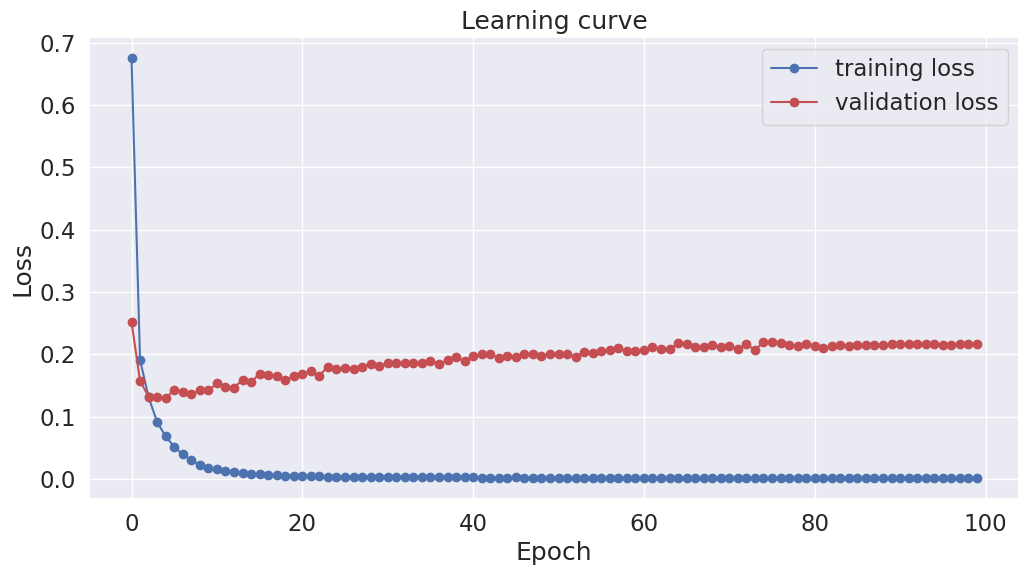

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [29]:
q = len(labels)-1
print(acc(False,q))
acc(True, q)


308 1.0
0.7109002078440373
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________1___________________

Predict labels:  ['Metal', 'Metal', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________18___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Chemical Compound', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compou

___________________40___________________

Predict labels:  ['Element', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont

___________________62___________________

Predict labels:  ['0', '0', '0', '0', 'Metal', '0', 'Metal', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Inorganic Solvent', 'I-cont', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', '0', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', 'Metal', 'Metal', '0',

___________________88___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'O-cont', 'O-cont', 'O-cont', 'O-cont', 'O-cont', 'O-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'O-cont', 

___________________113___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'T-cont', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysi

___________________135___________________

Predict labels:  ['Element', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', 'H-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', '0', 'pH', 'P-cont']
Actual labels:  ['0', '

___________________160___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', 'Element', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '

___________________184___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Element', '0', 'Element', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', '0', 'Separation Method', 'Separation Method', 'S-cont', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________209___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________210___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0

___________________232___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'A-cont', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Separation Method', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0']
Actual labels:  ['0', '0', '0', '0', '0'

___________________253___________________

Predict labels:  ['0', '0', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'H-cont', '0', 'Separation Method', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

___________________272___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Element Group', '0',

___________________290___________________

Predict labels:  ['0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', 'Element',

___________________309___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________329___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'pH', 'P-cont', 'P-cont', 'P-cont', 'P-cont', 'P-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual

0.7109002078440373

In [30]:
t = len(label_test)-1
print(acc_test(False,t))
print(acc_test(True,t))

37 1.0
0.6983701399805946
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', 'Acid', '0', '0', 'Separation Method', 'S-cont', '0', 'Separation Method', '0', '0', 'Separation Method', 'S-cont', '0', 'Separation Method', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', '0', 'Acid', 'A-cont', '0', '0', 'Separation Method', '0', 'Separation Method', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', '0', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', 'Separation Me

___________________20___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S

___________________42___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', '0', 'Method of Analysis', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', 'Method of Analysis', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 

___________________65___________________

Predict labels:  ['0', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', '0', '0', 'Separation Method', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

___________________84___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Resin', 'Resin', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [31]:
model = torch.load("test.ck")
model.eval()

print(acc(False, q))
print(acc(True, q))

308 1.0
0.7138877703977418
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________1___________________

Predict labels:  ['Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________18___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Chemical Compound', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '

___________________40___________________

Predict labels:  ['Element', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Separ

___________________62___________________

Predict labels:  ['0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', '0', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', 'Metal', 'Metal', '0', 

___________________87___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________88___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Me

___________________112___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual label

___________________134___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Chemical Compound', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Acid', 'A-cont', '0', '0', '0', 'Acid', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0',

___________________159___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

___________________182___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', '0', '0', 'Acid', 'A-cont', '0', '0', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', '0', '0', 'Acid', 'A-cont', '0', '0', 'Chemical Compound', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0',

___________________206___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Y-cont', 'Y-cont', '0', '0', 'Y-cont', 'Yield', 'Yield', 'Yield', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'I

___________________229___________________

Predict labels:  ['0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', 'Separation Method', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Separation Method', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Elem

___________________250___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

___________________270___________________

Predict labels:  ['0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', 'Organic solvent', 'Organic solvent', '0', '0', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'I-cont', 'P-cont', 'Acid Concentration', 'C-cont', 'C-cont', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0

___________________288___________________

Predict labels:  ['Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '

___________________307___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Reagent', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Reagent', '0', '0', '0', '0',

___________________327___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

In [32]:
print(acc_test(False, t))
print(acc_test(True, t))

37 1.0
0.6716484259863199
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', 'Acid', '0', '0', 'Separation Method', 'S-cont', '0', 'Separation Method', '0', '0', 'Separation Method', 'S-cont', '0', 'Separation Method', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', '0', '0', '0', '0', 'Acid', 'A-cont', '0', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', '0', 'Acid', 'A-cont', '0', '0', 'Separation Method', '0', 'Separation Method', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', 'A-cont', 'A-cont', '0', 'Acid', 'Acid', 'Acid', 'Acid', '

___________________20___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S

___________________43___________________

Predict labels:  ['0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', 'Y-cont', 'Y-cont', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________66___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Y-cont', 'Y-cont', 'Y-c

___________________85___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', '0', '0', '0', '0', '0', '0', 'Separation Method', '0', '0', '0', 'S-cont', '0', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '